# **Heat detection algorithm**
This notebook is exploring two methods to detect heat spikes in timeseries data.  
The fisrt one is the one implemented by mathieu with a markvo auto-regression.  
The second one is alexandre method with diff + strong threshold.

___
Imports

In [1]:
#! /usr/bin/env python
#coding: utf-8

from numpy import *
import pandas as pd
from matplotlib.pyplot import *
import statsmodels.api as sm
from matplotlib.pyplot import *
import os as os
import hvplot.pandas
import xarray as xr
import hvplot.xarray
import pandas as pd
# def plot_detect_warm_plume(df,directory,number):

#     # plot results
#     fig = figure(figsize=(20,10))
#     fig.add_subplot(4, 1, 1)
#     df['temperature'].plot()
#     ylabel('temperature')
#     scatter(df.temperature.index[1:],df.temperature[1:],marker='o',c=df['predicted_label'][1:],cmap='seismic',alpha=1)
#     fig.add_subplot(4, 1, 2)
#     df['pressure'].plot()
#     ylabel('pressure')
#     scatter(df.pressure.index[1:],df.pressure[1:],marker='o',c=df['predicted_label'][1:],cmap='seismic',alpha=1)
#     fig.add_subplot(4, 1, 3)
#     df['dTemp'].plot()
#     ylabel('dTemp')
#     scatter(df.dTemp.index[1:],df.dTemp[1:],marker='o',c=df['predicted_label'][1:],cmap='seismic',alpha=1)
#     fig.add_subplot(4, 1, 4)
#     df['dPressure'].plot()
#     ylabel('dPressure')
#     scatter(df.dPressure.index[1:],df.dPressure[1:],marker='o',c=df['predicted_label'][1:],cmap='seismic',alpha=1)
#     if not os.access(directory, os.F_OK):
#         os.makedirs(directory)
#     filename = '{}/{}_unsupervised_classifier.png'.format(directory,number)
#     savefig(filename, dpi=150)
#     print('Wrote file', filename)

In [2]:
# comment if you want hvplot interactives renders
hvplot.extension('matplotlib')

In [3]:
# Silencing some warnings for lisibility of the multiple plots
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [5]:
# Importing the list of tags identified by mathieu as wrong
flag_warm = True
if flag_warm == True:    
    warm_plume = pd.read_csv("s3://gfts-ifremer/tags/bargip/bar_flag_warm_plume.txt",sep = "\t")
    
    tag_list = list(warm_plume[warm_plume["warm_plume"]==True]["tag_name"])

tag_list

['DK_A10502',
 'DK_A10507',
 'DK_A10516',
 'DK_A10521',
 'DK_A10526',
 'DK_A10531',
 'DK_A10543',
 'DK_A10572',
 'DK_A10574',
 'DK_A10580',
 'DK_A10600',
 'DK_A10602',
 'DK_A10611',
 'DK_A10620',
 'DK_A10625',
 'DK_A10632',
 'DK_A10647',
 'DK_A10650']

## 1 : Markov Autoregression

In [33]:
tag_name = "DK_A10600"

In [34]:
# Accessing and formatting data for the model
data_path = f"s3://gfts-ifremer/tags/bargip/cleaned/{tag_name}/"

storage_path = f"powerpant_output/detection/{tag_name}"

# read tag data
df = pd.read_csv(f"{data_path}dst.csv", delimiter = ',')

df['time'] = pd.to_datetime(df['time'])
df = df.set_index("time")


In [35]:
# Groupping by day

df_d = df.loc[df.groupby(pd.Grouper(freq='D'))['temperature'].idxmax()] # nan introduced because of daylight saving time change
#df_d = df.groupby(pd.Grouper(freq='D')).mean() # nan introduced because of daylight saving time change
idx = np.where(np.isnan(df_d['temperature']))[0]
for i in idx:
    df_d['pressure'][i] = df_d['pressure'][i-1] # put the pressure value of the hour before
    df_d['temperature'][i] = df_d['temperature'][i-1] # put the temperature value of the hour before
df_d['dTemp'] = np.append(np.diff(df_d['temperature']), 0.0)
df_d['dPressure'] = np.append(np.diff(df_d['pressure']), 0.0)
df_d.index = pd.DatetimeIndex(df_d.index).to_period('D')

clf_model = sm.tsa.MarkovAutoregression(df_d['temperature'], k_regimes=2, order=1, switching_ar=False)
res_clf_model = clf_model.fit(method='bfgs')
res_clf_model.summary()

predicted_label = res_clf_model.smoothed_marginal_probabilities[0] > 0.50
# Ajuster la longueur en ajoutant des zéros (ou tout autre valeur que tu juges pertinente)
predicted_label = np.append(np.zeros(df_d.shape[0] - len(predicted_label)), predicted_label)
df_d['predicted_label'] = predicted_label
if df_d['temperature'][df_d['predicted_label']==1.0].mean() < df_d['temperature'][df_d['predicted_label']==0.0].mean():
    df_d['predicted_label'] = df_d['predicted_label'] + 1.0
    df_d['predicted_label'][df_d['predicted_label'] == 2.0] = 0.0

In [36]:
# Adding in the initial dataframe the predictions

# Initializing the column
df['predicted_label'] = np.nan

# Running through every prediction
for date in df_d.index:
    # Extract the predicted value
    predicted_label_value = df_d.loc[date, 'predicted_label']
    
    # Extending the value for the whole day.
    df.loc[df.index.to_period('D') == date, 'predicted_label'] = predicted_label_value

# Replacing remaining nans with 0
df['predicted_label'].fillna(0, inplace=True)


In [37]:
df.index

DatetimeIndex(['2014-06-09 22:00:00+00:00', '2014-06-09 22:01:30+00:00',
               '2014-06-09 22:03:00+00:00', '2014-06-09 22:04:30+00:00',
               '2014-06-09 22:06:00+00:00', '2014-06-09 22:07:30+00:00',
               '2014-06-09 22:09:00+00:00', '2014-06-09 22:10:30+00:00',
               '2014-06-09 22:12:00+00:00', '2014-06-09 22:13:30+00:00',
               ...
               '2015-09-23 13:27:00+00:00', '2015-09-23 13:28:30+00:00',
               '2015-09-23 13:30:00+00:00', '2015-09-23 13:31:30+00:00',
               '2015-09-23 13:33:00+00:00', '2015-09-23 13:34:30+00:00',
               '2015-09-23 13:36:00+00:00', '2015-09-23 13:37:30+00:00',
               '2015-09-23 13:39:00+00:00', '2015-09-23 13:40:30+00:00'],
              dtype='datetime64[ns, UTC]', name='time', length=451828, freq=None)

#### The above cell upsample the predicted label for visualisation purposes

:Overlay
   .Curve.Temperature   :Curve   [time]   (temperature)
   .Scatter.Temperature :Scatter   [time]   (temperature)
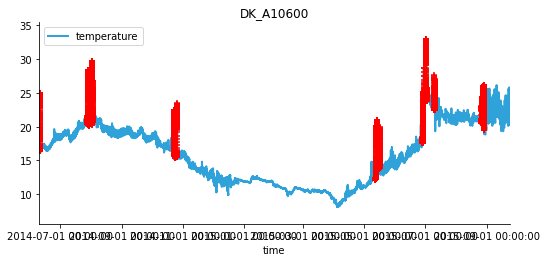

In [38]:
df["temperature"].hvplot(title =tag_name) * (df[df["predicted_label"]>0]["temperature"]).hvplot.scatter(color="red",marker="+")

#### The red dots are the moments where the fish is in a warm plume

___
### Now we apply this algorithm for all the tags in the identified list, we are just displaying them here, not saving any, it will be done in a further step.

:Overlay
   .Curve.Temperature   :Curve   [index]   (temperature)
   .Scatter.Temperature :Scatter   [index]   (temperature)
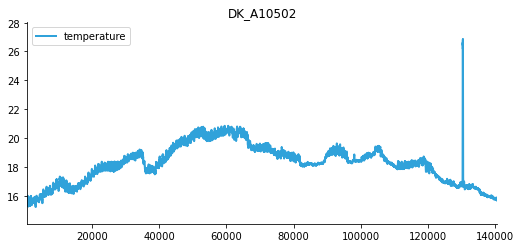

:Overlay
   .Curve.Temperature   :Curve   [index]   (temperature)
   .Scatter.Temperature :Scatter   [index]   (temperature)
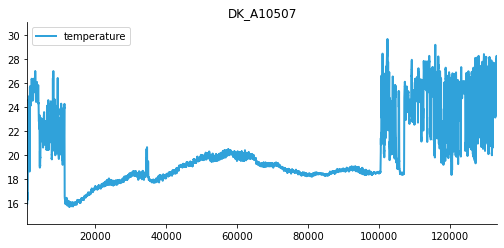

:Overlay
   .Curve.Temperature   :Curve   [index]   (temperature)
   .Scatter.Temperature :Scatter   [index]   (temperature)
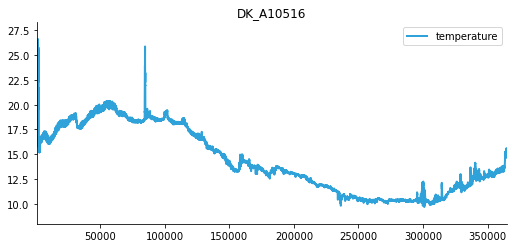

:Overlay
   .Curve.Temperature   :Curve   [index]   (temperature)
   .Scatter.Temperature :Scatter   [index]   (temperature)
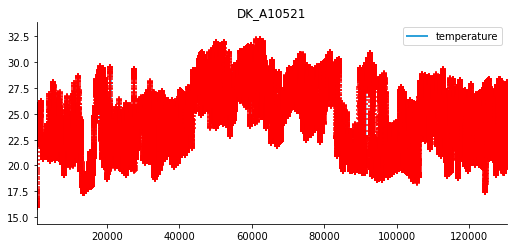

:Overlay
   .Curve.Temperature   :Curve   [index]   (temperature)
   .Scatter.Temperature :Scatter   [index]   (temperature)
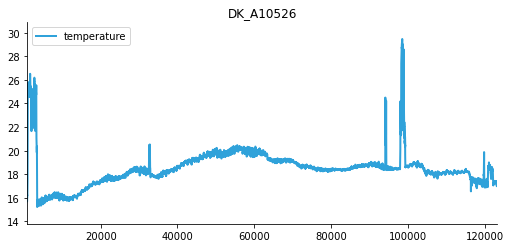

:Overlay
   .Curve.Temperature   :Curve   [index]   (temperature)
   .Scatter.Temperature :Scatter   [index]   (temperature)
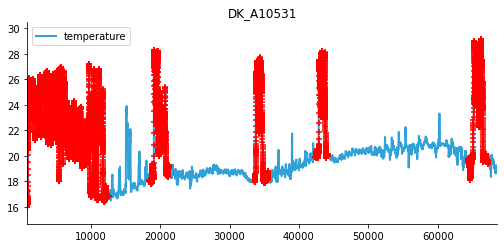

:Overlay
   .Curve.Temperature   :Curve   [index]   (temperature)
   .Scatter.Temperature :Scatter   [index]   (temperature)
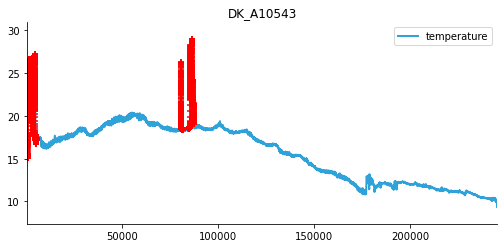

:Overlay
   .Curve.Temperature   :Curve   [index]   (temperature)
   .Scatter.Temperature :Scatter   [index]   (temperature)
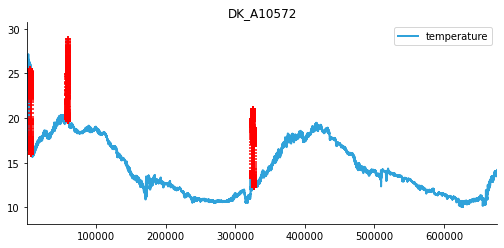

:Overlay
   .Curve.Temperature   :Curve   [index]   (temperature)
   .Scatter.Temperature :Scatter   [index]   (temperature)
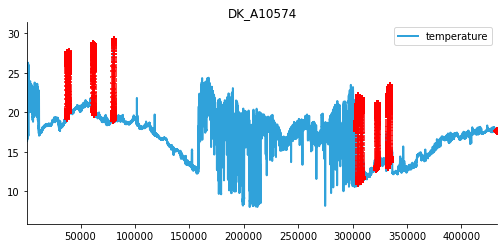

:Overlay
   .Curve.Temperature   :Curve   [index]   (temperature)
   .Scatter.Temperature :Scatter   [index]   (temperature)
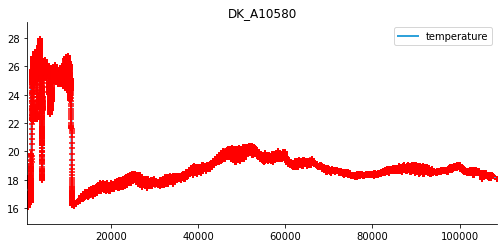

:Overlay
   .Curve.Temperature   :Curve   [index]   (temperature)
   .Scatter.Temperature :Scatter   [index]   (temperature)
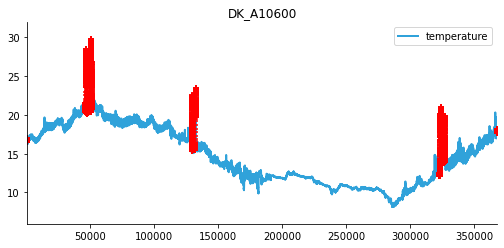

ValueError: cannot reindex on an axis with duplicate labels

In [11]:
for tag_name in tag_list:
    data_path = f"s3://gfts-ifremer/tags/bargip/cleaned/{tag_name}/"
    
    # storage_path = f"powerpant_output/detection/{tag_name}"
    
    # read tag data
    df = pd.read_csv(f"{data_path}dst.csv", delimiter = ',')
    df['time'] = pd.to_datetime(df['time'])
    df = df.set_index("time")
    # format
    df_d = df.loc[df.groupby(pd.Grouper(freq='D'))['temperature'].idxmax()] # nan introduced because of daylight saving time change
    #df_d = df.groupby(pd.Grouper(freq='D')).mean() # nan introduced because of daylight saving time change
    idx = np.where(np.isnan(df_d['temperature']))[0]
    for i in idx:
        df_d['pressure'][i] = df_d['pressure'][i-1] # put the pressure value of the hour before
        df_d['temperature'][i] = df_d['temperature'][i-1] # put the temperature value of the hour before
    df_d['dTemp'] = np.append(np.diff(df_d['temperature']), 0.0)
    df_d['dPressure'] = np.append(np.diff(df_d['pressure']), 0.0)
    df_d.index = pd.DatetimeIndex(df_d.index).to_period('D')
    
    clf_model = sm.tsa.MarkovAutoregression(df_d['temperature'], k_regimes=2, order=1, switching_ar=False)
    res_clf_model = clf_model.fit(method='bfgs')
    res_clf_model.summary()
    
    predicted_label = res_clf_model.smoothed_marginal_probabilities[0] > 0.50
    # Ajuster la longueur en ajoutant des zéros (ou tout autre valeur que tu juges pertinente)
    predicted_label = np.append(np.zeros(df_d.shape[0] - len(predicted_label)), predicted_label)
    df_d['predicted_label'] = predicted_label
    if df_d['temperature'][df_d['predicted_label']==1.0].mean() < df_d['temperature'][df_d['predicted_label']==0.0].mean():
        df_d['predicted_label'] = df_d['predicted_label'] + 1.0
        df_d['predicted_label'][df_d['predicted_label'] == 2.0] = 0.0
    
    df['predicted_label'] = np.nan
    
    for date in df_d.index:
    
        predicted_label_value = df_d.loc[date, 'predicted_label']
        
        df.loc[df.index.to_period('D') == date, 'predicted_label'] = predicted_label_value
    
    df['predicted_label'].fillna(0, inplace=True)

    tagging_events = pd.read_csv(f"{data_path}tagging_events.csv", delimiter=",")
    df = df.reset_index()
    # Filtering tagging events
    cond = (df["time"] > tagging_events["time"][0]) & (df["time"] < tagging_events["time"][1])
    df = df.where(cond).dropna()
    
    display(df["temperature"].hvplot(title =tag_name) * (df[df["predicted_label"]>0]["temperature"]).hvplot.scatter(color="red",marker="+"))

## 2 : Diff and threshold

:Overlay
   .Curve.Temperature          :Curve   [time]   (temperature)
   .Scatter.Detected_Anomalies :Scatter   [time]   (temperature)
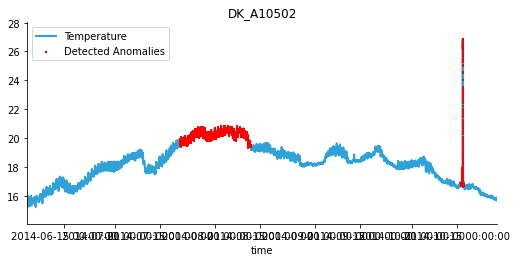

:Overlay
   .Curve.Temperature          :Curve   [time]   (temperature)
   .Scatter.Detected_Anomalies :Scatter   [time]   (temperature)
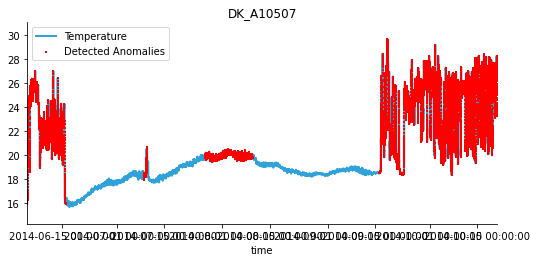

:Overlay
   .Curve.Temperature          :Curve   [time]   (temperature)
   .Scatter.Detected_Anomalies :Scatter   [time]   (temperature)
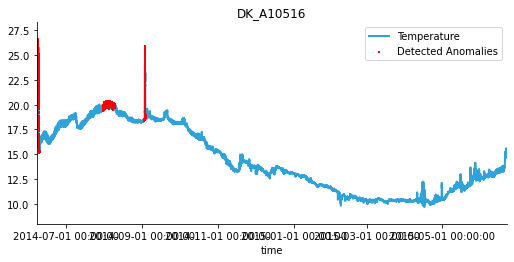

:Overlay
   .Curve.Temperature          :Curve   [time]   (temperature)
   .Scatter.Detected_Anomalies :Scatter   [time]   (temperature)
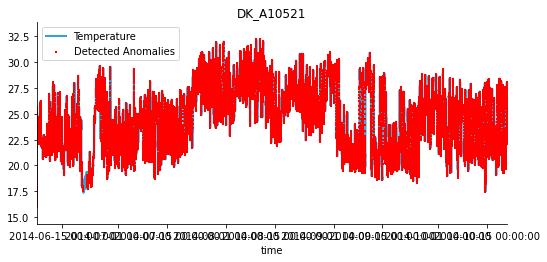

:Overlay
   .Curve.Temperature          :Curve   [time]   (temperature)
   .Scatter.Detected_Anomalies :Scatter   [time]   (temperature)
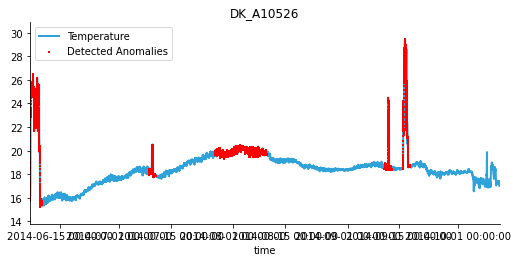

:Overlay
   .Curve.Temperature          :Curve   [time]   (temperature)
   .Scatter.Detected_Anomalies :Scatter   [time]   (temperature)
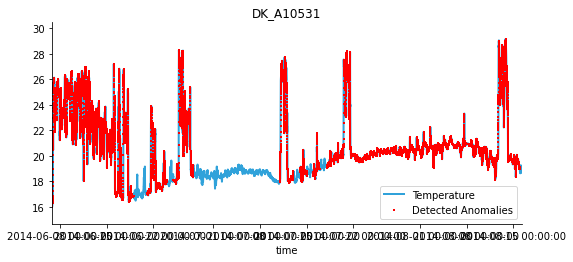

:Overlay
   .Curve.Temperature          :Curve   [time]   (temperature)
   .Scatter.Detected_Anomalies :Scatter   [time]   (temperature)
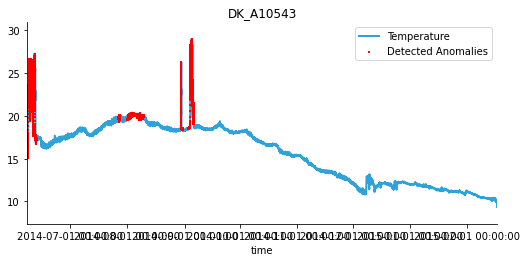

:Overlay
   .Curve.Temperature          :Curve   [time]   (temperature)
   .Scatter.Detected_Anomalies :Scatter   [time]   (temperature)
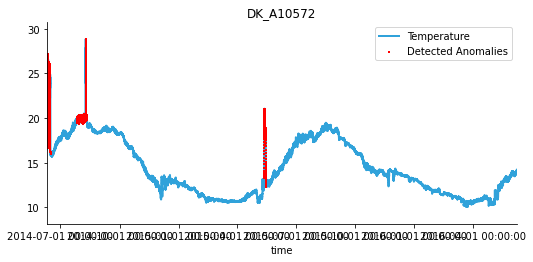

:Overlay
   .Curve.Temperature          :Curve   [time]   (temperature)
   .Scatter.Detected_Anomalies :Scatter   [time]   (temperature)
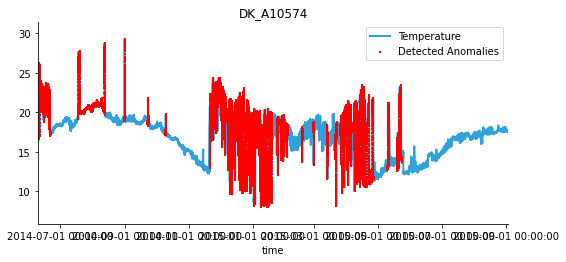

:Overlay
   .Curve.Temperature          :Curve   [time]   (temperature)
   .Scatter.Detected_Anomalies :Scatter   [time]   (temperature)
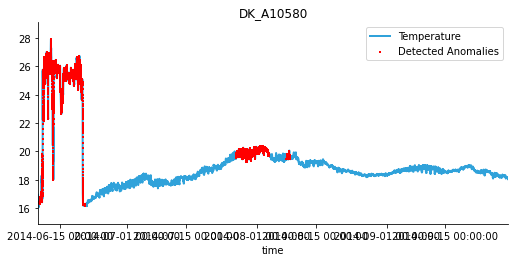

:Overlay
   .Curve.Temperature          :Curve   [time]   (temperature)
   .Scatter.Detected_Anomalies :Scatter   [time]   (temperature)
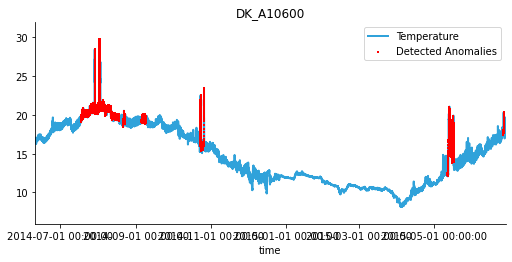

:Overlay
   .Curve.Temperature          :Curve   [time]   (temperature)
   .Scatter.Detected_Anomalies :Scatter   [time]   (temperature)
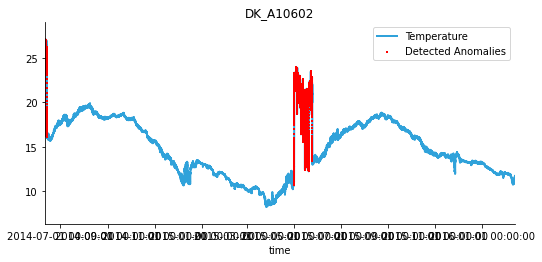

:Overlay
   .Curve.Temperature          :Curve   [time]   (temperature)
   .Scatter.Detected_Anomalies :Scatter   [time]   (temperature)
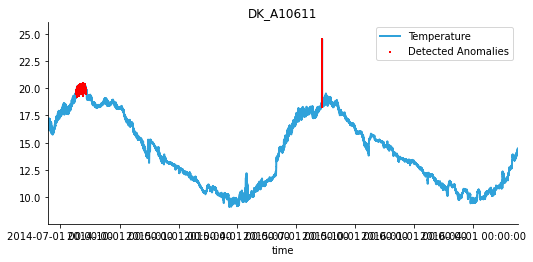

:Overlay
   .Curve.Temperature          :Curve   [time]   (temperature)
   .Scatter.Detected_Anomalies :Scatter   [time]   (temperature)
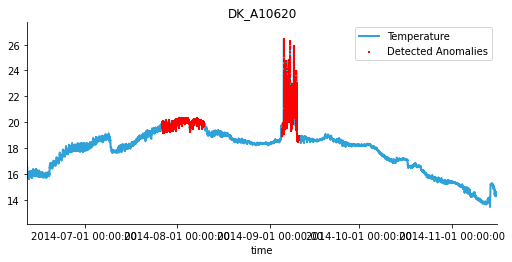

:Overlay
   .Curve.Temperature          :Curve   [time]   (temperature)
   .Scatter.Detected_Anomalies :Scatter   [time]   (temperature)
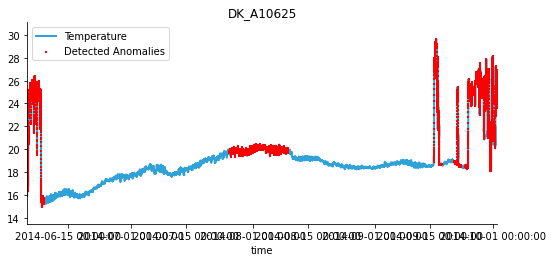

:Overlay
   .Curve.Temperature          :Curve   [time]   (temperature)
   .Scatter.Detected_Anomalies :Scatter   [time]   (temperature)
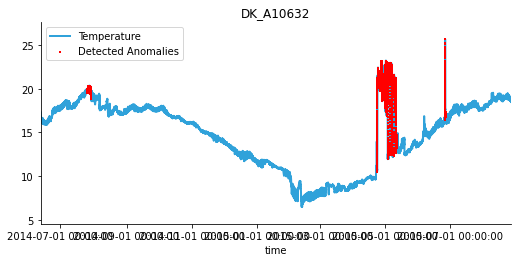

:Overlay
   .Curve.Temperature          :Curve   [time]   (temperature)
   .Scatter.Detected_Anomalies :Scatter   [time]   (temperature)
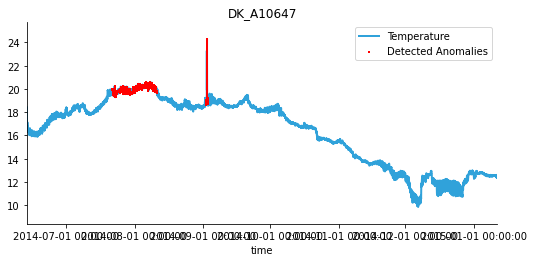

:Overlay
   .Curve.Temperature          :Curve   [time]   (temperature)
   .Scatter.Detected_Anomalies :Scatter   [time]   (temperature)
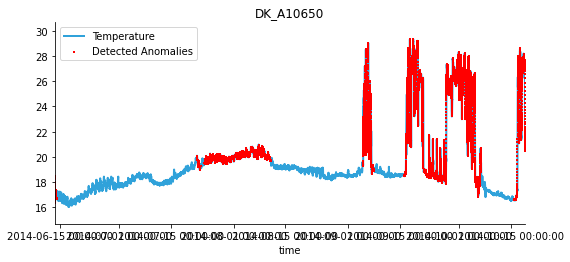

In [15]:
import pandas as pd
import hvplot.pandas  # Ensure hvplot is imported

for tag_name in tag_list:
    data_path = f"s3://gfts-ifremer/tags/bargip/cleaned/{tag_name}/"
    
    tagging_events = pd.read_csv(f"{data_path}tagging_events.csv", delimiter=",")
    df = pd.read_csv(f"{data_path}dst.csv", delimiter=',')
    
    # Filter data according to tagging events
    cond = (df["time"] > tagging_events["time"][0]) & (df["time"] < tagging_events["time"][1])
    df = df.where(cond).dropna()

    df['time'] = pd.to_datetime(df['time'])
    df = df.set_index('time')
    
    # Calculate the temperature difference
    df['temp_diff'] = abs(df["temperature"].diff())
    
    # Define a threshold for significant temperature rise
    diff_threshold = 0.2
    df['temp_rise'] = df['temp_diff'] > diff_threshold
    
    # Define a threshold for abnormal temperature values
    temp_threshold = 20.0  # Example threshold for abnormal temperatures
    df['abnormal_temp'] = df['temperature'] > temp_threshold
    
    # Combining both conditions for label
    df['predicted_label'] = (df['temp_rise'] | df['abnormal_temp']).astype(float)
    
    # Calculating daily anomaly
    df['date'] = df.index.date  # Extract date without time
    anomaly_days = df.groupby('date')['predicted_label'].transform('max')  # Find the max per day
    df['predicted_label'] = anomaly_days  # Update all rows for that day
    
    # Remove temporary date column
    df.drop(columns='date', inplace=True)
    
    # Plotting
    # Temperature plot
    line_plot = df["temperature"].hvplot.line(label='Temperature', line_width=2)
    
    # Scatter plot to display detected anomalies
    scatter_plot = df[df['predicted_label'] > 0]["temperature"].hvplot.scatter(
        label='Detected Anomalies', 
        color='red', 
        size=10,
        marker="+"
    )
    
    # Overlay the line plot and the scatter plot
    plot = line_plot * scatter_plot
    
    # Display the plot
    display(plot.opts(title=tag_name, height=400, width=800))


### 3. This section shows how to compute and push the data on the s3 bucket

In [39]:
tag_name = "DK_A10531"

In [40]:
data_path = f"../../all_cleaned/{tag_name}/"

In [41]:
storage_path = f"../../all_cleaned/{tag_name}"

In [6]:
warm_plume = pd.read_csv("s3://gfts-ifremer/tags/bargip/bar_flag_warm_plume.txt",sep = "\t")

tag_list = list(warm_plume[warm_plume["warm_plume"]==True]["tag_name"])

['DK_A10502',
 'DK_A10507',
 'DK_A10516',
 'DK_A10521',
 'DK_A10526',
 'DK_A10531',
 'DK_A10543',
 'DK_A10572',
 'DK_A10574',
 'DK_A10580',
 'DK_A10600',
 'DK_A10602',
 'DK_A10611',
 'DK_A10620',
 'DK_A10625',
 'DK_A10632',
 'DK_A10647',
 'DK_A10650']

In [11]:
data_path =f"../../all_cleaned/{tag_name}/"

In [42]:
### Diff + Threshold Method
def get_wp_timestamps(data_path,storage_path):
    df = pd.read_csv(f"{data_path}dst.csv", delimiter=',')
    
    df['time'] = pd.to_datetime(df['time'])
    df = df.set_index('time')
    
    # Calcul de la différence de température
    df['temp_diff'] = abs(df["temperature"].diff())
    
    # Définir un seuil pour la hausse significative de température
    diff_threshold = 0.2
    df['temp_rise'] = df['temp_diff'] > diff_threshold
    
    # Définir un seuil pour les valeurs de température anormales
    temp_threshold = 20.0  # Seuil d'exemple pour les températures anormales
    df['abnormal_temp'] = df['temperature'] > temp_threshold
    
    # Combiner les conditions pour créer une étiquette prédite finale
    df['predicted_label'] = (df['temp_rise'] | df['abnormal_temp']).astype(float)
    
    # Calculer les anomalies journalières : si une anomalie est présente, marquer toute la journée
    df['date'] = df.index.date  # Extraire la date sans l'heure
    anomaly_days = df.groupby('date')['predicted_label'].transform('max')  # Trouver le max par jour
    df['predicted_label'] = anomaly_days  # Mettre à jour toutes les lignes de cette journée
    
    # Supprimer la colonne temporaire 'date'
    df.drop(columns='date', inplace=True)
    
    # Plotting
    # Line plot de la température
    line_plot = df["temperature"].hvplot.line(label='Temperature', color='blue', line_width=2)
    
    # Scatter plot pour afficher les anomalies détectées
    scatter_plot = df[df['predicted_label'] > 0]["temperature"].hvplot.scatter(
        label='Detected Anomalies', 
        color='red', 
        size=5,
        marker="+"
    )
    
    # Superposer le line plot et le scatter plot
    plot = line_plot * scatter_plot
    
    # Afficher le plot
    display(plot.opts(title=tag_name, height=400, width=800))

    df_d = df.resample('D').max()
    df_d = df_d.reset_index()
    if df_d.loc[0, 'predicted_label'] == 1:
        df_d.loc[0, 'predicted_label'] = 0
    
    df_d['time'] = pd.to_datetime(df_d['time'], utc=True)
    df_d['time'] = df_d['time'].dt.strftime('%Y-%m-%d')
    df_d = df_d.set_index("time")
    
    df_d["predicted_label"].to_csv(f"{storage_path}/detection.csv")
    

### Adding it all to the tags data

In [61]:
import s3fs

s3 = s3fs.S3FileSystem(
    anon=False,
    client_kwargs={
        "endpoint_url": "https://s3.gra.perf.cloud.ovh.net",
    },
)

In [62]:
traj_state = pd.read_csv("s3://gfts-ifremer/tag/bargip/traj_state.csv",sep=";")

In [69]:
tag_list = [tag for tag in list(traj_state[traj_state["re_run"]==True]["tag_id"]) if "DK" in tag]

In [70]:
tag_list

['DK_A10499',
 'DK_A10507',
 'DK_A10513',
 'DK_A10521',
 'DK_A10525',
 'DK_A10526',
 'DK_A10527',
 'DK_A10531',
 'DK_A10536',
 'DK_A10543',
 'DK_A10552',
 'DK_A10553',
 'DK_A10574',
 'DK_A10579',
 'DK_A10580',
 'DK_A10581',
 'DK_A10595',
 'DK_A10602',
 'DK_A10620',
 'DK_A10625',
 'DK_A10630',
 'DK_A10632',
 'DK_A10647',
 'DK_A10650']

In [71]:
hvplot.extension('matplotlib')

  0%|          | 0/24 [00:00<?, ?it/s]WARNING:param.main: line_width option not found for line plot with matplotlib; similar options include: ['linewidth', 'min_width', 'width']
/srv/conda/envs/notebook/lib/python3.11/site-packages/holoviews/plotting/mpl/element.py:600: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = plot_fn(*plot_args, **plot_kwargs)


:Overlay
   .Curve.Temperature          :Curve   [time]   (temperature)
   .Scatter.Detected_Anomalies :Scatter   [time]   (temperature)
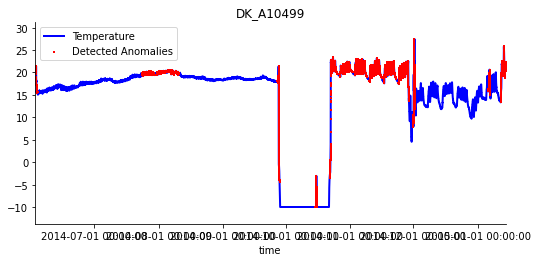

  4%|▍         | 1/24 [00:00<00:17,  1.30it/s]WARNING:param.main: line_width option not found for line plot with matplotlib; similar options include: ['linewidth', 'min_width', 'width']
/srv/conda/envs/notebook/lib/python3.11/site-packages/holoviews/plotting/mpl/element.py:600: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = plot_fn(*plot_args, **plot_kwargs)


:Overlay
   .Curve.Temperature          :Curve   [time]   (temperature)
   .Scatter.Detected_Anomalies :Scatter   [time]   (temperature)
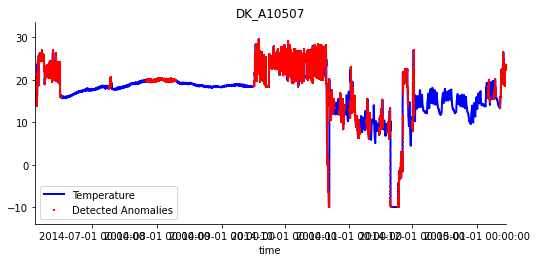

  8%|▊         | 2/24 [00:01<00:20,  1.08it/s]WARNING:param.main: line_width option not found for line plot with matplotlib; similar options include: ['linewidth', 'min_width', 'width']
/srv/conda/envs/notebook/lib/python3.11/site-packages/holoviews/plotting/mpl/element.py:600: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = plot_fn(*plot_args, **plot_kwargs)


:Overlay
   .Curve.Temperature          :Curve   [time]   (temperature)
   .Scatter.Detected_Anomalies :Scatter   [time]   (temperature)
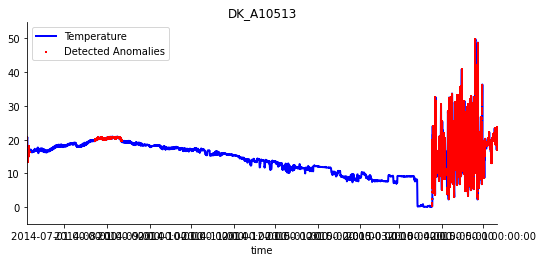

 12%|█▎        | 3/24 [00:02<00:20,  1.04it/s]WARNING:param.main: line_width option not found for line plot with matplotlib; similar options include: ['linewidth', 'min_width', 'width']
/srv/conda/envs/notebook/lib/python3.11/site-packages/holoviews/plotting/mpl/element.py:600: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = plot_fn(*plot_args, **plot_kwargs)


:Overlay
   .Curve.Temperature          :Curve   [time]   (temperature)
   .Scatter.Detected_Anomalies :Scatter   [time]   (temperature)
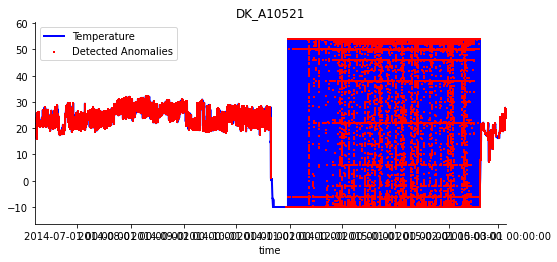

 17%|█▋        | 4/24 [00:04<00:25,  1.25s/it]WARNING:param.main: line_width option not found for line plot with matplotlib; similar options include: ['linewidth', 'min_width', 'width']
/srv/conda/envs/notebook/lib/python3.11/site-packages/holoviews/plotting/mpl/element.py:600: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = plot_fn(*plot_args, **plot_kwargs)


:Overlay
   .Curve.Temperature          :Curve   [time]   (temperature)
   .Scatter.Detected_Anomalies :Scatter   [time]   (temperature)
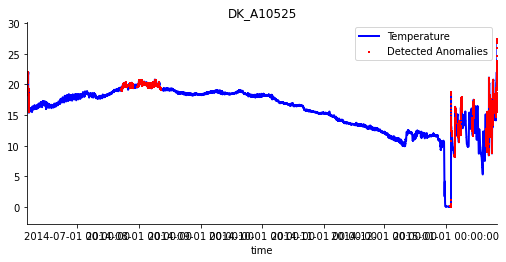

 21%|██        | 5/24 [00:05<00:18,  1.00it/s]WARNING:param.main: line_width option not found for line plot with matplotlib; similar options include: ['linewidth', 'min_width', 'width']
/srv/conda/envs/notebook/lib/python3.11/site-packages/holoviews/plotting/mpl/element.py:600: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = plot_fn(*plot_args, **plot_kwargs)


:Overlay
   .Curve.Temperature          :Curve   [time]   (temperature)
   .Scatter.Detected_Anomalies :Scatter   [time]   (temperature)
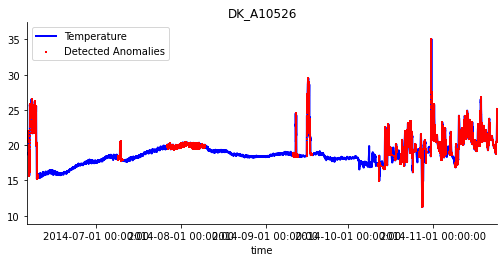

 25%|██▌       | 6/24 [00:05<00:15,  1.14it/s]WARNING:param.main: line_width option not found for line plot with matplotlib; similar options include: ['linewidth', 'min_width', 'width']
/srv/conda/envs/notebook/lib/python3.11/site-packages/holoviews/plotting/mpl/element.py:600: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = plot_fn(*plot_args, **plot_kwargs)


:Overlay
   .Curve.Temperature          :Curve   [time]   (temperature)
   .Scatter.Detected_Anomalies :Scatter   [time]   (temperature)
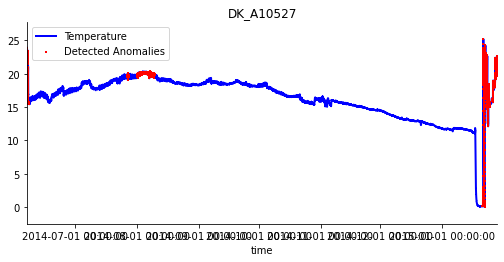

 29%|██▉       | 7/24 [00:06<00:13,  1.27it/s]WARNING:param.main: line_width option not found for line plot with matplotlib; similar options include: ['linewidth', 'min_width', 'width']
/srv/conda/envs/notebook/lib/python3.11/site-packages/holoviews/plotting/mpl/element.py:600: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = plot_fn(*plot_args, **plot_kwargs)


:Overlay
   .Curve.Temperature          :Curve   [time]   (temperature)
   .Scatter.Detected_Anomalies :Scatter   [time]   (temperature)
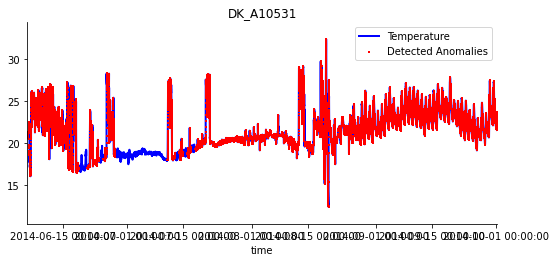

 33%|███▎      | 8/24 [00:06<00:11,  1.40it/s]WARNING:param.main: line_width option not found for line plot with matplotlib; similar options include: ['linewidth', 'min_width', 'width']
/srv/conda/envs/notebook/lib/python3.11/site-packages/holoviews/plotting/mpl/element.py:600: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = plot_fn(*plot_args, **plot_kwargs)


:Overlay
   .Curve.Temperature          :Curve   [time]   (temperature)
   .Scatter.Detected_Anomalies :Scatter   [time]   (temperature)
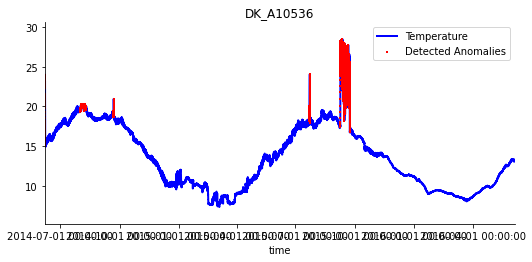

 38%|███▊      | 9/24 [00:08<00:13,  1.13it/s]WARNING:param.main: line_width option not found for line plot with matplotlib; similar options include: ['linewidth', 'min_width', 'width']
/srv/conda/envs/notebook/lib/python3.11/site-packages/holoviews/plotting/mpl/element.py:600: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = plot_fn(*plot_args, **plot_kwargs)


:Overlay
   .Curve.Temperature          :Curve   [time]   (temperature)
   .Scatter.Detected_Anomalies :Scatter   [time]   (temperature)
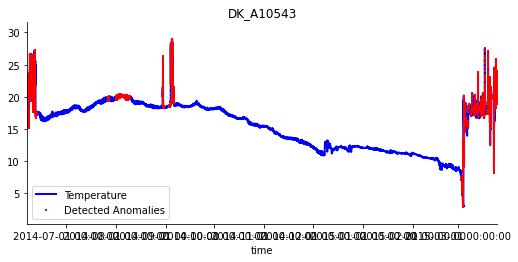

 42%|████▏     | 10/24 [00:08<00:12,  1.15it/s]WARNING:param.main: line_width option not found for line plot with matplotlib; similar options include: ['linewidth', 'min_width', 'width']
/srv/conda/envs/notebook/lib/python3.11/site-packages/holoviews/plotting/mpl/element.py:600: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = plot_fn(*plot_args, **plot_kwargs)


:Overlay
   .Curve.Temperature          :Curve   [time]   (temperature)
   .Scatter.Detected_Anomalies :Scatter   [time]   (temperature)
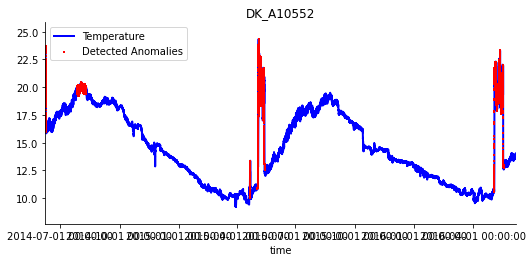

 46%|████▌     | 11/24 [00:10<00:13,  1.05s/it]WARNING:param.main: line_width option not found for line plot with matplotlib; similar options include: ['linewidth', 'min_width', 'width']
/srv/conda/envs/notebook/lib/python3.11/site-packages/holoviews/plotting/mpl/element.py:600: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = plot_fn(*plot_args, **plot_kwargs)


:Overlay
   .Curve.Temperature          :Curve   [time]   (temperature)
   .Scatter.Detected_Anomalies :Scatter   [time]   (temperature)
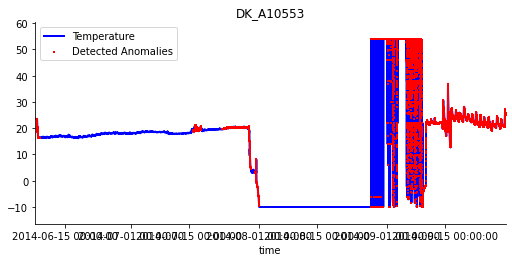

 50%|█████     | 12/24 [00:10<00:10,  1.13it/s]WARNING:param.main: line_width option not found for line plot with matplotlib; similar options include: ['linewidth', 'min_width', 'width']
/srv/conda/envs/notebook/lib/python3.11/site-packages/holoviews/plotting/mpl/element.py:600: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = plot_fn(*plot_args, **plot_kwargs)


:Overlay
   .Curve.Temperature          :Curve   [time]   (temperature)
   .Scatter.Detected_Anomalies :Scatter   [time]   (temperature)
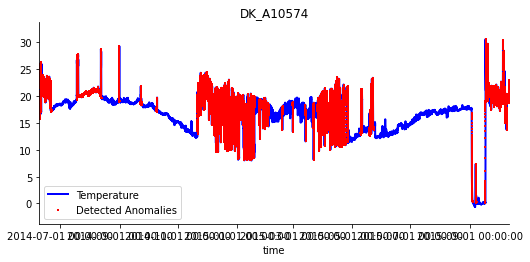

 54%|█████▍    | 13/24 [00:12<00:13,  1.21s/it]WARNING:param.main: line_width option not found for line plot with matplotlib; similar options include: ['linewidth', 'min_width', 'width']
/srv/conda/envs/notebook/lib/python3.11/site-packages/holoviews/plotting/mpl/element.py:600: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = plot_fn(*plot_args, **plot_kwargs)


:Overlay
   .Curve.Temperature          :Curve   [time]   (temperature)
   .Scatter.Detected_Anomalies :Scatter   [time]   (temperature)
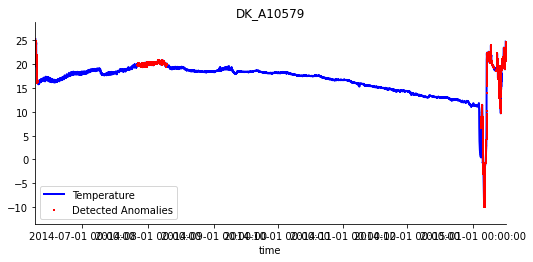

 58%|█████▊    | 14/24 [00:13<00:10,  1.05s/it]WARNING:param.main: line_width option not found for line plot with matplotlib; similar options include: ['linewidth', 'min_width', 'width']
/srv/conda/envs/notebook/lib/python3.11/site-packages/holoviews/plotting/mpl/element.py:600: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = plot_fn(*plot_args, **plot_kwargs)


:Overlay
   .Curve.Temperature          :Curve   [time]   (temperature)
   .Scatter.Detected_Anomalies :Scatter   [time]   (temperature)
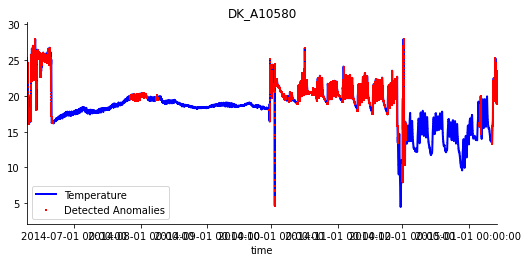

 62%|██████▎   | 15/24 [00:14<00:09,  1.09s/it]WARNING:param.main: line_width option not found for line plot with matplotlib; similar options include: ['linewidth', 'min_width', 'width']
/srv/conda/envs/notebook/lib/python3.11/site-packages/holoviews/plotting/mpl/element.py:600: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = plot_fn(*plot_args, **plot_kwargs)


:Overlay
   .Curve.Temperature          :Curve   [time]   (temperature)
   .Scatter.Detected_Anomalies :Scatter   [time]   (temperature)
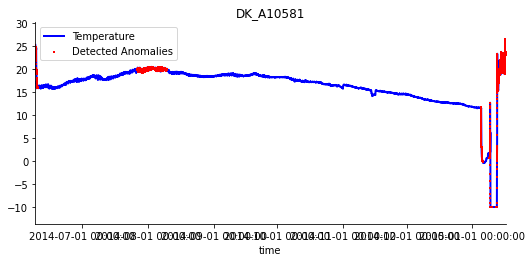

 67%|██████▋   | 16/24 [00:15<00:07,  1.07it/s]WARNING:param.main: line_width option not found for line plot with matplotlib; similar options include: ['linewidth', 'min_width', 'width']
/srv/conda/envs/notebook/lib/python3.11/site-packages/holoviews/plotting/mpl/element.py:600: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = plot_fn(*plot_args, **plot_kwargs)


:Overlay
   .Curve.Temperature          :Curve   [time]   (temperature)
   .Scatter.Detected_Anomalies :Scatter   [time]   (temperature)
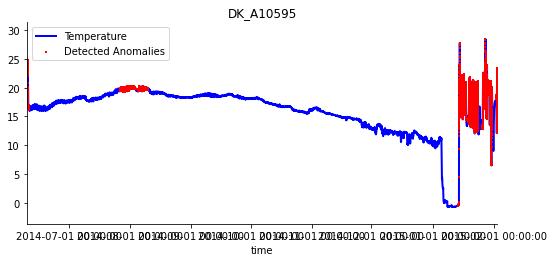

 71%|███████   | 17/24 [00:15<00:05,  1.18it/s]WARNING:param.main: line_width option not found for line plot with matplotlib; similar options include: ['linewidth', 'min_width', 'width']
/srv/conda/envs/notebook/lib/python3.11/site-packages/holoviews/plotting/mpl/element.py:600: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = plot_fn(*plot_args, **plot_kwargs)


:Overlay
   .Curve.Temperature          :Curve   [time]   (temperature)
   .Scatter.Detected_Anomalies :Scatter   [time]   (temperature)
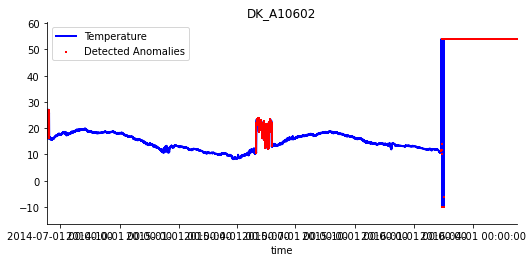

 75%|███████▌  | 18/24 [00:17<00:06,  1.13s/it]WARNING:param.main: line_width option not found for line plot with matplotlib; similar options include: ['linewidth', 'min_width', 'width']
/srv/conda/envs/notebook/lib/python3.11/site-packages/holoviews/plotting/mpl/element.py:600: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = plot_fn(*plot_args, **plot_kwargs)


:Overlay
   .Curve.Temperature          :Curve   [time]   (temperature)
   .Scatter.Detected_Anomalies :Scatter   [time]   (temperature)
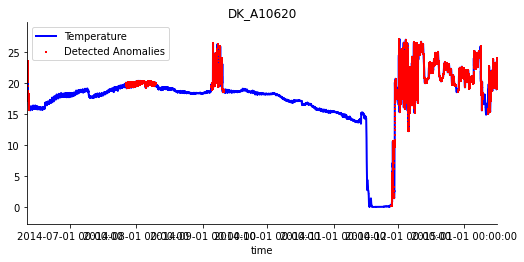

 79%|███████▉  | 19/24 [00:18<00:05,  1.01s/it]WARNING:param.main: line_width option not found for line plot with matplotlib; similar options include: ['linewidth', 'min_width', 'width']
/srv/conda/envs/notebook/lib/python3.11/site-packages/holoviews/plotting/mpl/element.py:600: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = plot_fn(*plot_args, **plot_kwargs)


:Overlay
   .Curve.Temperature          :Curve   [time]   (temperature)
   .Scatter.Detected_Anomalies :Scatter   [time]   (temperature)
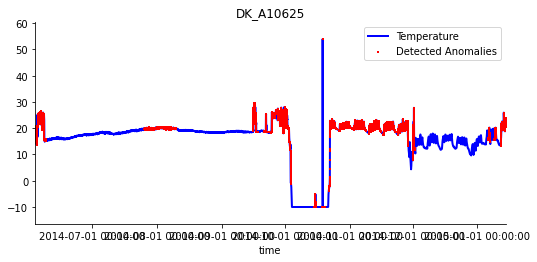

 83%|████████▎ | 20/24 [00:19<00:03,  1.11it/s]WARNING:param.main: line_width option not found for line plot with matplotlib; similar options include: ['linewidth', 'min_width', 'width']
/srv/conda/envs/notebook/lib/python3.11/site-packages/holoviews/plotting/mpl/element.py:600: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = plot_fn(*plot_args, **plot_kwargs)


:Overlay
   .Curve.Temperature          :Curve   [time]   (temperature)
   .Scatter.Detected_Anomalies :Scatter   [time]   (temperature)
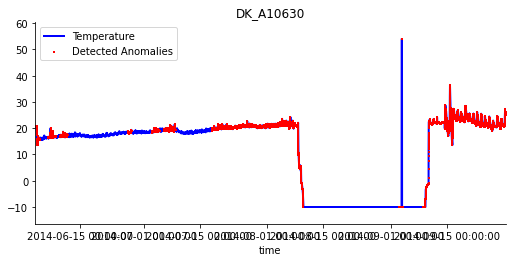

 88%|████████▊ | 21/24 [00:19<00:02,  1.26it/s]WARNING:param.main: line_width option not found for line plot with matplotlib; similar options include: ['linewidth', 'min_width', 'width']
/srv/conda/envs/notebook/lib/python3.11/site-packages/holoviews/plotting/mpl/element.py:600: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = plot_fn(*plot_args, **plot_kwargs)


:Overlay
   .Curve.Temperature          :Curve   [time]   (temperature)
   .Scatter.Detected_Anomalies :Scatter   [time]   (temperature)
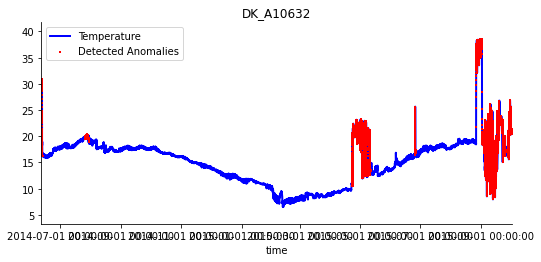

 92%|█████████▏| 22/24 [00:20<00:01,  1.11it/s]WARNING:param.main: line_width option not found for line plot with matplotlib; similar options include: ['linewidth', 'min_width', 'width']
/srv/conda/envs/notebook/lib/python3.11/site-packages/holoviews/plotting/mpl/element.py:600: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = plot_fn(*plot_args, **plot_kwargs)


:Overlay
   .Curve.Temperature          :Curve   [time]   (temperature)
   .Scatter.Detected_Anomalies :Scatter   [time]   (temperature)
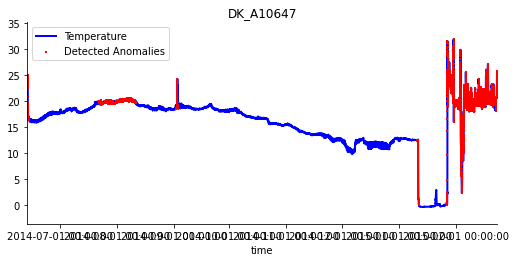

 96%|█████████▌| 23/24 [00:21<00:00,  1.18it/s]WARNING:param.main: line_width option not found for line plot with matplotlib; similar options include: ['linewidth', 'min_width', 'width']
/srv/conda/envs/notebook/lib/python3.11/site-packages/holoviews/plotting/mpl/element.py:600: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = plot_fn(*plot_args, **plot_kwargs)


:Overlay
   .Curve.Temperature          :Curve   [time]   (temperature)
   .Scatter.Detected_Anomalies :Scatter   [time]   (temperature)
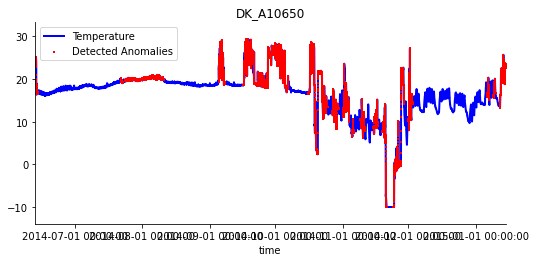

100%|██████████| 24/24 [00:22<00:00,  1.08it/s]


In [20]:
# Update with your path
for tag_name in tqdm(tag_list, desc=""):
    data_path = f"../../all_cleaned/{tag_name}/"
    storage_path = f"../../all_cleaned/{tag_name}"
    get_wp_timestamps(data_path,storage_path)

In [2]:
# Run this cell if you want to put all tags in it

import s3fs

s3 = s3fs.S3FileSystem(
    anon=False,
    client_kwargs={
        "endpoint_url": "https://s3.gra.perf.cloud.ovh.net",
    },
)
s3.put("../../all_cleaned/","gfts-ifremer/tags/bargip/cleaned",recursive=True)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [21]:
# Run this cell if you want only to update the files with detections

import s3fs

s3 = s3fs.S3FileSystem(
    anon=False,
    client_kwargs={
        "endpoint_url": "https://s3.gra.perf.cloud.ovh.net",
    },
)

for tag in tag_list:
    s3.put(f"../../all_cleaned/{tag}",f"gfts-ifremer/tags/bargip/cleaned/{tag}",recursive=True)